In [2]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, BasicAer
from qiskit.tools.visualization import circuit_drawer
np.set_printoptions(precision=7, suppress=True)

backend_statevector = BasicAer.get_backend('statevector_simulator')
q, c = QuantumRegister(1), ClassicalRegister(1)

Classical probability distributions can be written as a stochastic vector, which can be transformed to another stochastic vector by applying a stochastic matrix. In other words, the evolution of stochastic vectors can be described by a stochastic matrix.

Quantum states also evolve and their evolution is described by unitary matrices. This leads to some interesting properties in quantum computing. Unitary evolution is true for a closed system, that is, a quantum system perfectly isolated from the environment. This is not the case in the quantum computers we have today: these are open quantum systems that evolve differently due to to uncontrolled interactions with the environment. In this notebook, we take a glimpse at both types of evolution.


# Unitary evolution

A unitary matrix has the property that its conjugate transpose is its inverse. Formally, it means that a matrix $U$ is unitary if $UU^\dagger=U^\dagger U=\mathbb{1}$, where $^\dagger$ stands for conjugate transpose, and $\mathbb{1}$ is the identity matrix. A quantum computer is a machine that implements unitary operations.

As an example, we have seen the NOT operation before, which is performed by the X gate in a quantum computer. While the generic discussion on gates will only occur in a subsequent notebook, we can study the properties of the X gate. Its matrix representation is $X = \begin{bmatrix} 0 & 1\\ 1 & 0\end{bmatrix}$. Let's check if it is indeed unitary:

In [3]:
X = np.array([[0, 1], [1, 0]])

print("X X†\n")
print(X.dot(X.T.conj()))

print("\nX† X\n")
print(X.T.conj().dot(X))

X X†

[[1 0]
 [0 1]]

X† X

[[1 0]
 [0 1]]


It looks like a legitimate unitary operation. The unitary nature ensures that the $l_2$ norm is preserved, that is, quantum states are mapped to quantum states.

In [4]:
zero_ket = np.array([[1], [0]])

print("The norm of the state |0> before applying X = %f\n" % np.linalg.norm(zero_ket))
print("The norm of the state after applying X = %f" % np.linalg.norm(X.dot(zero_ket)))

The norm of the state |0> before applying X = 1.000000

The norm of the state after applying X = 1.000000


Furthermore, since the unitary operation is a matrix, it is linear. Measurements are also represented by matrices. These two observations imply that everything a quantum computer implements is actually linear. If we want to see some form of nonlinearity, that must involve some classical intervention.

Another consequence of the unitary operations is reversibility. Any unitary operation can be reversed. Quantum computing libraries often provide a function to reverse entire circuits. Reversing the X gate is simple: we just apply it again (its conjugate transpose is itself, therefore $X^2=\mathbb{1}$).

This is in stark contrast to digital computation where each transformation applied to the digital data loses information.

In [6]:
circuit = QuantumCircuit(q, c)
circuit.x(q[0])
circuit.x(q[0])
job = execute(circuit, backend_statevector)
print(job.result().get_statevector(circuit))

[1.+0.j 0.+0.j]


which is exactly $|0\rangle$ as we would expect.

In the next notebook, you will learn about classical and quantum many-body systems and the Hamiltonian. In the notebook on adiabatic quantum computing, you will learn that **a unitary operation is in fact the Schrödinger equation solved for a Hamiltonian for some duration of time**. This connects the computer science way of thinking about gates and unitary operations to actual physics, but there is some learning to be done before we can make that connection. Before that, let us take another look at the interaction with the environment.

# Interaction with the environment: open systems

Actual quantum systems are seldom closed: they constantly interact with their environment in a largely uncontrolled fashion, which causes them to lose coherence. This is true for current and near-term quantum computers too.  This also means that **their actual time evolution is not described by a unitary matrix as we would want it**, but some other operator (the technical name for it is a completely positive trace-preserving map).

Quantum computing libraries often offer a variety of noise models that mimic different types of interaction, and increasing the strength of the interaction with the environment leads to faster decoherence. The timescale for decoherence is often called $T_2$ time. Among a couple of other parameters, $T_2$ time is critically important for the number of gates or the duration of the quantum computation we can perform.

A very cheap way of studying the effects of decoherence is mixing a pure state with the maximally mixed state $\mathbb{1}/2^d$, where $d$ is the number of qubits, with some visibility parameter in $[0,1]$. This way we do not have to specify noise models or any other map modelling decoherence. For instance, we can mix the 

$$|\phi = \dfrac{|00\rangle + |11\rangle}{\sqrt{2}} $$ state with the maximally mixed state:

In [7]:
def mixed_state(densityMatrix, visibility):
    maximally_mixed_state = np.eye(4) / 2**2
    return (visibility * densityMatrix) + (1 - visibility) * maximally_mixed_state

øKet = np.array([[1], [0], [0], [1]]) / np.sqrt(2)
øBra = øKet.T.conj()

øRho = øKet.dot(øBra)
print('density matrix of |ø>\n\n', øRho)

density matrix of |ø>

 [[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]


where we can see that there are indeed non-zero off diagonal components demonstrating the "quantumness" of the state.

In [8]:
print("Maximum visibility is a pure state:")
print(mixed_state(øRho, 1.0))

print("The state is still entangled with visibility 0.8:")
print(mixed_state(øRho, 0.5))

print("No coherence left:")
print(mixed_state(øRho, 0))

Maximum visibility is a pure state:
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]
The state is still entangled with visibility 0.8:
[[0.375 0.    0.    0.25 ]
 [0.    0.125 0.    0.   ]
 [0.    0.    0.125 0.   ]
 [0.25  0.    0.    0.375]]
No coherence left:
[[0.25 0.   0.   0.  ]
 [0.   0.25 0.   0.  ]
 [0.   0.   0.25 0.  ]
 [0.   0.   0.   0.25]]


Another way to look at what happens to a quantum state in an open system is through equilibrium processes. Think of a cup of coffee: left alone, it will equilibrate with the environment, eventually reaching the temperature of the environment. This includes energy exchange. A quantum state does the same thing and the environment has a defined temperature, just the environment of a cup of coffee.

The equilibrium state is called the thermal state. It has a very specific structure and we will revisit it, but for now, suffice to say that the energy of the samples pulled out of a thermal state follows a Boltzmann distribution. The Boltzmann -- also called Gibbs -- distribution is described as $P(E_i) = \frac {e^{-E_{i}/T}}{\sum _{j=1}^{M}{e^{-E_{j}/T}}}$, where $E_i$ is an energy, and $M$ is the total number of possible energy levels. Temperature enters the definition: the higher the temperature, the closer we are to the uniform distribution. In the infinite temperature limit, it recovers the uniform distribution. At high temperatures, all energy levels have an equal probability. In contrast, at zero temperature, the entire probability mass is concentrated on the lowest energy level, the ground state energy. To get a sense of this, let's plot the Boltzmann distribution with vastly different temperatures:

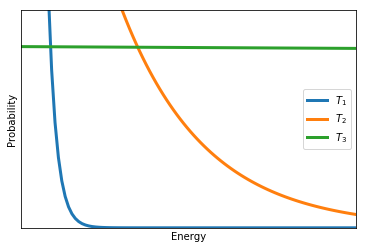

In [9]:
import matplotlib.pyplot as plt

temperatures = [.5, 5, 2000]
energies = np.linspace(0, 20, 100)

fig, ax = plt.subplots()

for i, T in enumerate(temperatures):
    probabilities = np.exp(-energies/T)
    Z = probabilities.sum()
    probabilities /= Z
    ax.plot(energies, probabilities, linewidth=3, label = "$T_" + str(i+1)+"$")

ax.set_xlim(0, 20); ax.set_ylim(0, 1.2 * probabilities.max())
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel('Energy'); ax.set_ylabel('Probability'); ax.legend()

Here $T_1<T_2<T_3$. Notice that $T_1$ is a low temperature, and therefore it is highly peaked at low energy levels. In contrast, $T_3$ is a very high temperature and the probability distribution is almost completely flat.